In [1]:
import os

import matplotlib.pyplot as plt
import torch
import pyro

import torch

from torch.utils.data import DataLoader

import pyro

from cities.modeling.simple_linear import SimpleLinear
from cities.modeling.svi_inference import run_svi_inference
from cities.utils.data_loader import select_from_data
from pyro.infer import Predictive


smoke_test = "CI" in os.environ
n = 20 if smoke_test else 2000
num_samples = 10 if smoke_test else 1000
n_steps = 10 if smoke_test else 1000

from cities.utils.data_grabber import find_repo_root

root = find_repo_root()

In [2]:
zoning_data_path = os.path.join(root, "data/minneapolis/processed/zoning_dataset.pt")

zoning_dataset_read = torch.load(zoning_data_path)

zoning_loader = DataLoader(
    zoning_dataset_read, batch_size=len(zoning_dataset_read), shuffle=True
)

data = next(iter(zoning_loader))

kwarg_names = {
    "categorical": ["limit_id", "neighborhood_id"],
    "continuous": {"parcel_area"},
    "outcome": "housing_units",
}

data_selected = select_from_data(data, kwarg_names)

[iteration 0001] loss: 573.7087
[iteration 0050] loss: 477.2619
[iteration 0100] loss: 449.5209
[iteration 0150] loss: 432.2536
[iteration 0200] loss: 424.3389
[iteration 0250] loss: 422.6832
[iteration 0300] loss: 410.5975
[iteration 0350] loss: 411.2444
[iteration 0400] loss: 411.3405
[iteration 0450] loss: 408.1781
[iteration 0500] loss: 416.1007
[iteration 0550] loss: 411.7660
[iteration 0600] loss: 410.9763
[iteration 0650] loss: 413.9548
[iteration 0700] loss: 404.2632
[iteration 0750] loss: 407.6868
[iteration 0800] loss: 410.2972
[iteration 0850] loss: 413.0002
[iteration 0900] loss: 417.5191
[iteration 0950] loss: 414.1737
[iteration 1000] loss: 416.2287


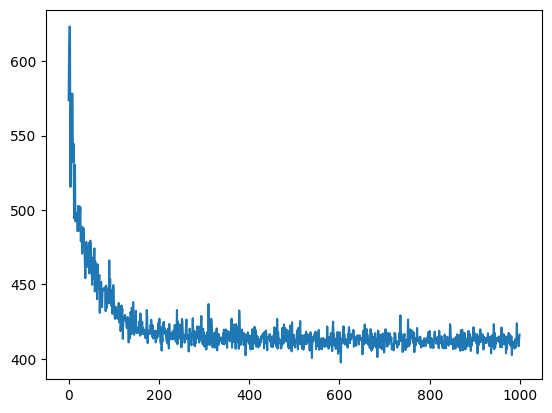

In [3]:
linear_model = SimpleLinear(**data_selected)

guide = run_svi_inference(
    linear_model, n_steps=n_steps, lr=0.01, verbose=True, **data_selected
)

In [4]:
predictive = Predictive(
    linear_model, guide=guide, num_samples=num_samples, parallel=True
)

samples = predictive(**data_selected)

1000


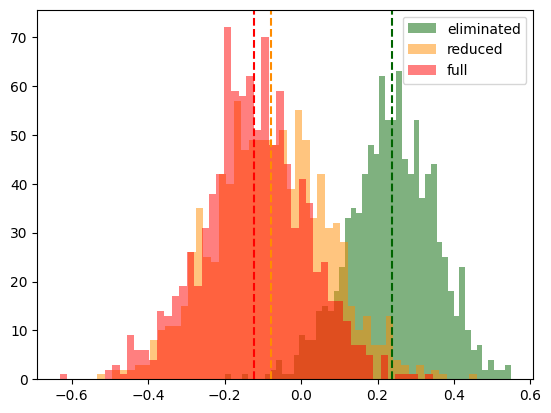

In [5]:
samples.keys()

limit_samples = samples["weights_categorical_limit_id"].squeeze()

limit_samples.shape

eliminated = limit_samples[:, 0]
reduced = limit_samples[:, 1]
full = limit_samples[:, 2]

print(len(eliminated))

plt.hist(eliminated, bins=50, alpha=0.5, color="darkgreen", label="eliminated")
plt.hist(reduced, bins=50, alpha=0.5, color="darkorange", label="reduced")
plt.hist(full, bins=50, alpha=0.5, color="red", label="full")
# add colored lines for means
plt.axvline(eliminated.mean(), color="darkgreen", linestyle="--")
plt.axvline(reduced.mean(), color="darkorange", linestyle="--")
plt.axvline(full.mean(), color="red", linestyle="--")
plt.legend()
plt.show()

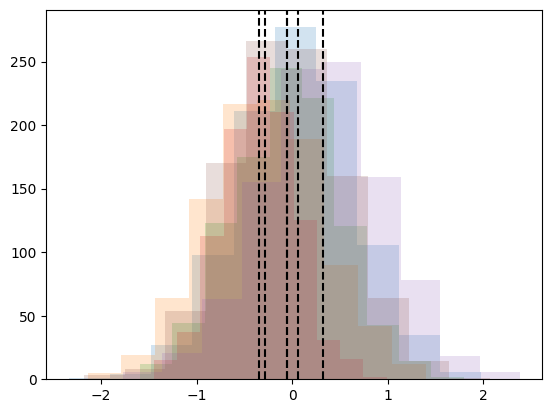

In [6]:
neighborhood_id_samples = samples["weights_categorical_neighborhood_id"].squeeze()
neighborhood_id_samples.shape

for i in [1, 4, 5, 23, 52, 60]:
    plt.hist(neighborhood_id_samples[:, i], alpha=0.2)
    plt.axvline(neighborhood_id_samples[:, i].mean(), color="black", linestyle="--")

plt.show()

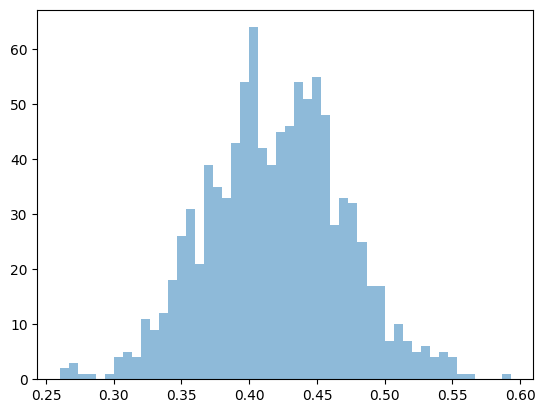

In [7]:
weight_parcel_area = samples["weight_continuous"].squeeze()

plt.hist(weight_parcel_area, bins=50, alpha=0.5)
plt.show()

[iteration 0001] loss: 455.7941
[iteration 0050] loss: 424.1648
[iteration 0100] loss: 432.7936
[iteration 0150] loss: 427.6473
[iteration 0200] loss: 424.6418
[iteration 0250] loss: 425.3359
[iteration 0300] loss: 424.6443
[iteration 0350] loss: 425.1449
[iteration 0400] loss: 424.7047
[iteration 0450] loss: 424.9653
[iteration 0500] loss: 425.4373
[iteration 0550] loss: 424.7868
[iteration 0600] loss: 423.7920
[iteration 0650] loss: 424.2324
[iteration 0700] loss: 425.1989
[iteration 0750] loss: 425.2789
[iteration 0800] loss: 425.5349
[iteration 0850] loss: 426.1353
[iteration 0900] loss: 425.5259
[iteration 0950] loss: 424.8751
[iteration 1000] loss: 424.3222


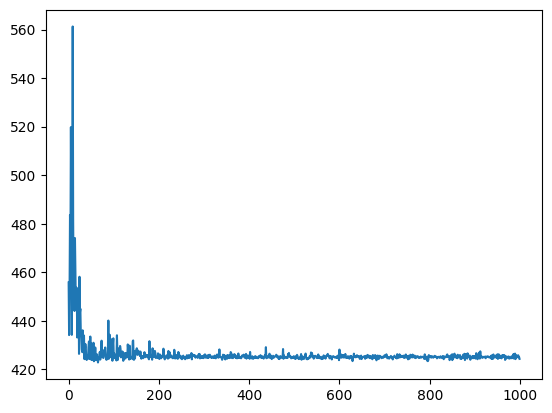

In [8]:
# compare what happens when we only use limits, no parcel area (see performance tests though)
# clear pyro param
pyro.clear_param_store()

limit_kwarg_names = {
    "categorical": ["limit_id"],
    "continuous": {},
    "outcome": "housing_units",
}

limit_data = select_from_data(data, limit_kwarg_names)

linear_model_limit = SimpleLinear(**limit_data)

# linear_model_limit = condition(linear_model_limit, data = {"outcome_observed": outcome})


guide_limit = run_svi_inference(
    linear_model_limit, n_steps=n_steps, lr=0.01, verbose=True, **limit_data
)

1000


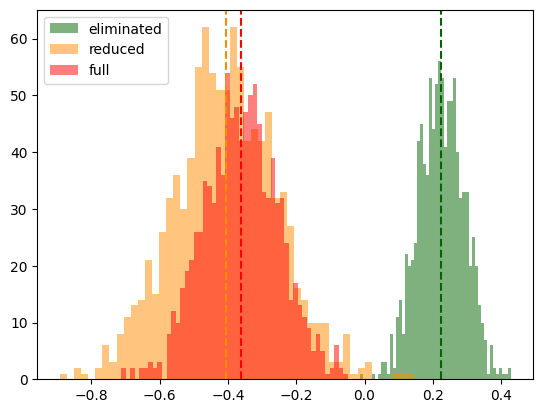

In [9]:
predictive_limit = Predictive(
    linear_model_limit, guide=guide_limit, num_samples=num_samples
)

samples_limit = predictive_limit(**limit_data)

samples_limit.keys()


limit_samples = samples_limit["weights_categorical_limit_id"].squeeze()

limit_samples.shape

eliminated = limit_samples[:, 0]
reduced = limit_samples[:, 1]
full = limit_samples[:, 2]

print(len(eliminated))

plt.hist(eliminated, bins=50, alpha=0.5, color="darkgreen", label="eliminated")
plt.hist(reduced, bins=50, alpha=0.5, color="darkorange", label="reduced")
plt.hist(full, bins=50, alpha=0.5, color="red", label="full")
# add colored lines for means
plt.axvline(eliminated.mean(), color="darkgreen", linestyle="--")
plt.axvline(reduced.mean(), color="darkorange", linestyle="--")
plt.axvline(full.mean(), color="red", linestyle="--")
plt.legend()
plt.show()